In [5]:
!pip install torch

In [4]:
import os
# hop to a local, healthy path (not on /projects or other EFS mounts)
os.chdir("/tmp")

In [6]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

import seaborn as sns

In [7]:
"""
Main modifications:

"""

'\nMain modifications:\n\n'

In [8]:
#!/usr/bin/env python
# === NOTES FOR THIS RUN ===
notes = """

test using all points and seasonal composites

"""
## Input
training_filename = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/l4a_t90km_t89_veg2022_zonal_HLS.gpkg'


# === DEFINE OUTPUT STRUCTURE ===
# Define/Create dirs
run_id = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
base_output_dir = '/'
output_directory = os.path.join(base_output_dir, run_id)

dir_checkpoints = os.path.join(output_directory, 'checkpoints')
os.makedirs(base_output_dir, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)


output_directory = os.path.join(base_output_dir, run_id)
scatterplot_path = os.path.join(output_directory, 'scatterplot_val_true_vs_pred.png')
predictions_df_path = os.path.join(output_directory, 'val_predictions.csv')
log_path = os.path.join(output_directory, 'run_notes_and_params.txt')



# === MODEL PARAMETERS ===
target_col = "agbd"
missing_data_strategy = 'interpolate' # drop or interpolate
target_range = (1, 1000) 
log_transform= False


hidden_dim = 64
n_blocks = 4
kernel_size = 3
# hidden_dim = 256
# n_blocks = 12
# kernel_size = 5

epochs = 1000
batch_size = 64
patience = 30
learning_rate = 1e-3
loss_function = nn.MSELoss()


random_state = 42



parameters = {
    "input_gpkg": training_filename,
    "target_col": target_col,
    "model": "ResNet1DAttn",
    "n_blocks": n_blocks,
    "hidden_dim": hidden_dim,
    "loss_function": "MSELoss",
    "optimizer": "AdamW",
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs,
    "early_stopping_patience": patience,
    "random_state":random_state,


### Dataset preparation
    "missing_data_strategy": missing_data_strategy,
    "range_target_clip": target_range,
    "log_transform":log_transform,
}

# === SAVE NOTES AND PARAMETERS TO TEXT FILE ===
with open(log_path, 'w') as f:
    f.write("=== Notes ===\n")
    f.write(notes.strip() + "\n\n")
    f.write("=== Parameters ===\n")
    for key, value in parameters.items():
        f.write(f"{key}: {value}\n")




In [9]:
# Functions

def remove_outliers(df, columns):
    '''Sequential IQR filter across list of columns (strings)'''
    for col in columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
    
# Step 3: Define interpolation function
def interpolate_by_vi(df: pd.DataFrame, hls_by_time: dict, vis2model: tuple) -> pd.DataFrame:
    """
    Interpolate each VI separately across time (columns). 
    Assumes columns for a given time-step are provided in hls_by_time[timestep].
    """
    
    df = df.copy()

    # Transpose hls_by_time to group columns by VI
    vi_to_cols = {vi: [] for vi in vis2model}

    for timestep, vi_cols in hls_by_time.items():
        for col in vi_cols:
            for vi in vis2model:
                if col.endswith(vi):
                    vi_to_cols[vi].append(col)

    # Interpolate each VI time series independently
    for vi, cols in vi_to_cols.items():
        sorted_cols = sorted(cols)  # ensure temporal order
        df[sorted_cols] = df[sorted_cols].interpolate(axis=1, limit_direction="both")

    return df

def preprocess_hls_df(
    df: pd.DataFrame,
    hls_cols: list,
    target_col: str = "agbd",
    strategy: str = "interpolate",  # options: "interpolate" or "drop"
    fill_value: float = 0,
    range_target_clip: tuple = (0, 500),
    log_transform: bool = False,
    hls_by_time = None,
    vis2model = None
) -> pd.DataFrame:
    """
    Preprocess the HLS dataframe by handling missing data and transforming the target.
    
    Parameters:
        df (pd.DataFrame): Original dataframe
        hls_cols (list): List of HLS column names
        target_col (str): Name of the AGBD column
        strategy (str): "interpolate" or "drop"
        fill_value (float): Value to fill after interpolation (if used)
        range_target_clip (tuple): (min, max) values to clip AGBD
        log_transform (bool): Whether to apply log1p transform to AGBD
    
    Returns:
        pd.DataFrame: Processed dataframe
    """
    df = df.copy()

    # Step 1: Ensure all HLS columns are numeric
    df[hls_cols] = df[hls_cols].apply(pd.to_numeric, errors="coerce")

    if strategy == "interpolate":
        # Interpolate NDVI time series across time (columns)
        # df[hls_cols] = df[hls_cols].interpolate(axis=1, limit_direction='both') ####* was this interpolating in sequence for different vis? Removed and edited
        interpolated = interpolate_by_vi(df, hls_by_time, vis2model)
        df[hls_cols] = interpolated[hls_cols]
        # Optional: if any NaNs still remain, drop those rows
        df = df.dropna(subset=hls_cols)

    elif strategy == "drop":
        # Drop rows with any NaNs in predictors
        df = df.dropna(subset=hls_cols)

    else:
        raise ValueError(f"Invalid strategy: '{strategy}'. Use 'interpolate' or 'drop'.")

    # Optional: Clip AGBD to remove extreme outliers
    if range_target_clip is not None:
        df = df[(df[target_col] > range_target_clip[0]) & (df[target_col] < range_target_clip[1])]

    # Optional: Log-transform the AGBD target
    if log_transform:
        log_col = f"{target_col}_log"
        df[log_col] = np.log1p(df[target_col])
        print(f"✅ Applied log1p transform to '{target_col}' → New column: '{log_col}'")
    
    print(f"✅ Preprocessed DataFrame: {len(df)} rows")
    return df


    
def predict(model, dataloader, log_transform=False):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        # for xb, yb in dataloader:
        #     xb = xb.to(device)
        #     pred = model(xb).cpu().numpy()
        #     yb = yb.cpu().numpy()
        #     preds.extend(pred)
        #     targets.extend(yb)
            
        # Suggested change check later
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)                # [B] or [B,1]
            if pred.ndim == 2 and pred.shape[1] == 1:
                pred = pred.squeeze(1)
            preds.extend(pred.detach().cpu().numpy().ravel().tolist())
            targets.extend(yb.detach().cpu().numpy().ravel().tolist())

    preds = np.array(preds)
    targets = np.array(targets)

    # Reverse log-transform if needed
    if log_transform == True:
        preds = np.expm1(preds)
        targets = np.expm1(targets)

    return preds, targets


    


    
# === DATASET CLASS ===

# class HLSDataset(Dataset):
#     """
#     HLSDataset used as input in 1DCNN
#     Expects:
#       - df: dataframe with HLS columns and target column
#       - hls_by_time: dict {timestep_key: [list_of_band_columns_for_that_time]}
#       - target_col: name of target column
#     Builds X with shape [N, T, B] where:
#       N = number of samples / rows
#       T = number of timesteps = len(sorted(hls_by_time.keys()))
#       B = number of bands per timestep = len(hls_by_time[t])
#     """
    
#     def __init__(self, df, hls_by_time, target_col=target_col):
#         self.X = []
#         self.y = df[target_col].astype("float32").values
#         for _, row in df.iterrows():
#             sample = []
#             for t in sorted(hls_by_time.keys()):
#                 bands = row[hls_by_time[t]].values.astype("float32")
#                 sample.append(bands)
#             self.X.append(sample)
#         self.X = torch.tensor(self.X)  # Shape: [N, T, B]
#         self.y = torch.tensor(self.y)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]


# Check this
class HLSDataset(Dataset):
    """
    Expects:
      - df: dataframe with HLS columns and target column
      - hls_by_time: dict {timestep_key: [list_of_band_columns_for_that_time]}
      - target_col: name of target column
    Builds X with shape [N, T, B] where:
      N = number of samples / rows
      T = number of timesteps = len(sorted(hls_by_time.keys()))
      B = number of bands per timestep = len(hls_by_time[t])
    """
    def __init__(self, df: pd.DataFrame, hls_by_time: dict, target_col: str = "agbd"):
        self.target = df[target_col].astype("float32").values
        # Build samples
        samples = []
        time_keys = sorted(hls_by_time.keys())
        for _, row in df.iterrows():
            per_time = []
            for t in time_keys:
                cols = hls_by_time[t]
                per_time.append(row[cols].values.astype("float32"))
            samples.append(np.stack(per_time, axis=0))  # [T, B]
        self.X = torch.tensor(np.stack(samples, axis=0))  # [N, T, B]
        self.y = torch.tensor(self.target)                # [N]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        


# class HLS1DCNN(nn.Module):
#     """
#     1DCNN
#     Input: [N, T, B]  -> permute -> [N, B, T]
#     Conv1d(in_channels=B, out_channels=hidden_dim, kernel_size=ks)
#     Conv1d(hidden_dim, hidden_dim, kernel_size=ks)
#     AdaptiveAvgPool1d(1) -> Flatten -> Linear(hidden_dim -> 1)
    
#     """
#     def __init__(self, in_channels, n_bands, hidden_dim=hidden_dim):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Conv1d(in_channels=n_bands, out_channels=hidden_dim, kernel_size=kernel_size, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=1),
#             nn.AdaptiveAvgPool1d(1),
#             nn.Flatten(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, x):
#         # Input shape: [B, T, BANDS] → Transpose to [B, BANDS, T]
#         x = x.permute(0, 2, 1)
#         return self.net(x).squeeze()

# EDITED
class HLS1DCNN(nn.Module):
    """
    Simple 1D CNN:
      Input: [N, T, B]  -> permute -> [N, B, T]
      Conv1d(in_channels=B, out_channels=hidden_dim, kernel_size=ks)
      Conv1d(hidden_dim, hidden_dim, kernel_size=ks)
      AdaptiveAvgPool1d(1) -> Flatten -> Linear(hidden_dim -> 1)
    """
    def __init__(self, n_bands: int, hidden_dim: int = 64, kernel_size: int = 3):
        super().__init__()
        padding = kernel_size // 2  # keep length
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=n_bands, out_channels=hidden_dim, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, padding=padding),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x: [N, T, B] -> [N, B, T]
        x = x.permute(0, 2, 1)
        out = self.net(x)
        return out.squeeze(1)  # [N]
        


# class ResidualBlock1D(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=1)
#         self.bn1 = nn.BatchNorm1d(channels)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=1)
#         self.bn2 = nn.BatchNorm1d(channels)

#     def forward(self, x):
#         identity = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += identity
#         return self.relu(out)
        
# EDITED
class ResidualBlock1D(nn.Module):
    def __init__(self, channels: int, kernel_size: int = 3):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + identity
        return self.relu(out)
        
# class AttentionPooling(nn.Module):
#     def __init__(self, channels, seq_len):
#         super().__init__()
#         self.attn = nn.Sequential(
#             nn.Conv1d(channels, 1, kernel_size=1),  # shape: [B, 1, T]
#             nn.Softmax(dim=-1)
#         )
    
#     def forward(self, x):
#         weights = self.attn(x)  # [B, 1, T]
#         return (x * weights).sum(dim=-1)  # Weighted sum over T


# Check
class AttentionPooling(nn.Module):
    """Additive 1x1 conv attention over time; returns weighted sum across T."""
    def __init__(self, channels: int):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(channels, 1, kernel_size=1),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        # x: [N, C, T]
        w = self.attn(x)          # [N, 1, T]
        return (x * w).sum(dim=-1)  # [N, C]
        

# class ResNet1DAttn(nn.Module):
#     def __init__(self, in_channels, seq_len, n_blocks=n_blocks, hidden_dim=64):
#         super().__init__()
#         self.input_proj = nn.Conv1d(in_channels, hidden_dim, kernel_size=1)
#         self.res_blocks = nn.Sequential(*[ResidualBlock1D(hidden_dim) for _ in range(n_blocks)])
#         self.attn_pool = AttentionPooling(hidden_dim, seq_len)
#         self.fc = nn.Linear(hidden_dim, 1)

#     def forward(self, x):
#         # x: [B, T, BANDS] → [B, BANDS, T]
#         x = x.permute(0, 2, 1)
#         x = self.input_proj(x)            # [B, H, T]
#         x = self.res_blocks(x)            # [B, H, T]
#         x = self.attn_pool(x)             # [B, H]
#         return self.fc(x).squeeze(1)      # [B]


class ResNet1DAttn(nn.Module):
    """
    ResNet-style 1D CNN with attention pooling.
    Input: [N, T, B] -> [N, B, T] -> 1x1 projection -> residual blocks -> attention pool -> FC
    """
    def __init__(self, n_bands: int, n_blocks: int = 3, hidden_dim: int = 64, kernel_size: int = 3):
        super().__init__()
        self.input_proj = nn.Conv1d(n_bands, hidden_dim, kernel_size=1)
        self.blocks = nn.Sequential(*[ResidualBlock1D(hidden_dim, kernel_size) for _ in range(n_blocks)])
        self.attn_pool = AttentionPooling(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)   # [N, B, T]
        x = self.input_proj(x)   # [N, H, T]
        x = self.blocks(x)       # [N, H, T]
        x = self.attn_pool(x)    # [N, H]
        return self.fc(x).squeeze(1)  # [N]


In [10]:
# === LOAD AND PREPARE DATA ===

training_df = gpd.read_file(training_filename)
training_df_backup = training_df.copy()


In [153]:
training_df = training_df_backup

In [11]:
training_df.columns

Index(['time', 'beam', 'elevation', 'shot_number', 'flags', 'sensitivity',
       'orbit', 'solar_elevation', 'track', 'agbd', 'year', 'month',
       'vegmask_2022', 'zone', 'HLS.2018.01.maxevi2.Blue_mean',
       'HLS.2018.01.maxevi2.EVI_mean', 'HLS.2018.01.maxevi2.EVI2_mean',
       'HLS.2018.01.maxevi2.Green_mean', 'HLS.2018.01.maxevi2.MSAVI_mean',
       'HLS.2018.01.maxevi2.NBR_mean', 'HLS.2018.01.maxevi2.NBR2_mean',
       'HLS.2018.01.maxevi2.NDMI_mean', 'HLS.2018.01.maxevi2.NDVI_mean',
       'HLS.2018.01.maxevi2.NIR_mean', 'HLS.2018.01.maxevi2.Red_mean',
       'HLS.2018.01.maxevi2.SAVI_mean', 'HLS.2018.01.maxevi2.SWIR_mean',
       'HLS.2018.01.maxevi2.SWIR2_mean', 'HLS.2018.01.maxevi2.TCB_mean',
       'HLS.2018.01.maxevi2.TCG_mean', 'HLS.2018.01.maxevi2.TCW_mean',
       'HLS.2018.01.maxevi2.Xgeo_mean', 'HLS.2018.01.maxevi2.Ygeo_mean',
       'HLS.2018.02.maxevi2.Blue_mean', 'HLS.2018.02.maxevi2.EVI_mean',
       'HLS.2018.02.maxevi2.EVI2_mean', 'HLS.2018.02.maxevi2.Green_

## Filtering and Intersect with AOI

In [12]:
# Remove outliers
training_df = remove_outliers(training_df, [target_col])

In [47]:
len(training_df)
# len(training_df_backup)
# training_df['chm_1m_mean'].isna().any()

21084

In [15]:
# plt.boxplot(training_df['chm_1m_mean'].dropna())
# plt.boxplot(training_df['agbd'])


In [16]:
## AGBD as a integer
# training_df["agbd"] = training_df["agbd"].round().astype(int)

In [17]:
# plt.boxplot(training_df["HLS.M30.2020.01-2020.04.median.v2.0.NIR_Narrow_median"])
# plt.boxplot(training_df["HLS.M30.2020.01-2020.04.median.v2.0.NDVI"])


In [18]:
# Filter year
# training_df["time2"] = pd.to_datetime(training_df["time"], errors="coerce", format='mixed')
# training_df["year"] = training_df["time2"].dt.year

# training_df = training_df.copy()
# training_df["time"] = training_df["time"].astype("Int64")  # keeps NaN but converts to nullable integer
# training_df = training_df[training_df['time'] <= 2022]


In [19]:
len(training_df)

21084

In [23]:
training_df.columns

Index(['time', 'beam', 'elevation', 'shot_number', 'flags', 'sensitivity',
       'orbit', 'solar_elevation', 'track', 'agbd', 'year', 'month',
       'vegmask_2022', 'zone', 'HLS.2018.01.maxevi2.Blue_mean',
       'HLS.2018.01.maxevi2.EVI_mean', 'HLS.2018.01.maxevi2.EVI2_mean',
       'HLS.2018.01.maxevi2.Green_mean', 'HLS.2018.01.maxevi2.MSAVI_mean',
       'HLS.2018.01.maxevi2.NBR_mean', 'HLS.2018.01.maxevi2.NBR2_mean',
       'HLS.2018.01.maxevi2.NDMI_mean', 'HLS.2018.01.maxevi2.NDVI_mean',
       'HLS.2018.01.maxevi2.NIR_mean', 'HLS.2018.01.maxevi2.Red_mean',
       'HLS.2018.01.maxevi2.SAVI_mean', 'HLS.2018.01.maxevi2.SWIR_mean',
       'HLS.2018.01.maxevi2.SWIR2_mean', 'HLS.2018.01.maxevi2.TCB_mean',
       'HLS.2018.01.maxevi2.TCG_mean', 'HLS.2018.01.maxevi2.TCW_mean',
       'HLS.2018.01.maxevi2.Xgeo_mean', 'HLS.2018.01.maxevi2.Ygeo_mean',
       'HLS.2018.02.maxevi2.Blue_mean', 'HLS.2018.02.maxevi2.EVI_mean',
       'HLS.2018.02.maxevi2.EVI2_mean', 'HLS.2018.02.maxevi2.Green_

In [25]:

#######################################
# Defining  predictors 
#######################################
# vis2model = (".NDVI", ".SAVI", ".EVI2")
# vis2model = (".NDVI")
vis2model = (
    # ".Red_median",
    # ".Green_median",
    # ".Blue_median",
    # ".NIR_Narrow_median",
    # ".SWIR1_median",
    # ".SWIR2_median",
    # VIS
    ".NDVI_mean",
    # ".EVI",
    ".EVI2_mean",
    # ".SAVI",
    ".MSAVI_mean",
    # ".NIRv",
    # ".kNDVI",
    # ".NDMI",
    ".NBR_mean",
    ".NBR2_mean",
    'TCB_mean',
    'TCG_mean',
    'TCW_mean'
    # ".GNDVI"
)


hls_cols = [
    col for col in training_df.columns
    if col.startswith("HLS") and 
        col.endswith(vis2model)
]


hls_cols[:3]
# len(hls_cols)


# hls_cols

['HLS.2018.01.maxevi2.EVI2_mean',
 'HLS.2018.01.maxevi2.MSAVI_mean',
 'HLS.2018.01.maxevi2.NBR_mean']

In [166]:
# # remove outliers NDVI
# ndvi_cols = [
#     col for col in hls_cols
#     if col.endswith(".NDVI")
# ]
# cols2clean = ndvi_cols
# training_df = training_df.copy()
# for col in cols2clean:
#     # print(col)
#     training_df = remove_outliers(training_df, [col])

In [26]:
len(training_df)

21084

In [27]:
# training_df_filtered = remove_outliers(training_df, ['HLS.M30.2021.05.v2.0.EVI2'])
# len(training_df_filtered)

In [28]:
# ndvi_cols = [col for col in training_df.columns if col.startswith("ndvi")]

# # Compute summary statistics
# training_df['ndvi_mean'] = training_df[ndvi_cols].mean(axis=1)
# training_df['ndvi_std'] = training_df[ndvi_cols].std(axis=1)

# # Remove samples with suspiciously flat or high NDVI values
# training_df_filtered = training_df[
#     (training_df['ndvi_std'] > 0.27) & (training_df['ndvi_mean'] < 0.9)
# ].copy()

# print(f"Removed {len(training_df) - len(training_df_filtered)} outliers based on NDVI.")


In [32]:
# Edit to get the time index depending on the name pattern
# time_index = sorted(set([
#     ".".join(col.split(".")[2:4])  # e.g. 2022.12
#     for col in hls_cols
# ]))
# time_index[:4]

time_index = sorted(set([
    ".".join(col.split(".")[1:3])  # e.g. 2022.12
    for col in hls_cols
]))
time_index


['2018.01', '2018.02']

In [33]:
# Group bands per timestamp
hls_by_time = {
    t: [col for col in hls_cols if f".{t}." in col] for t in time_index
}

In [172]:
# hls_by_time

In [34]:
# Check availability per time
availability = pd.DataFrame({
    t: training_df[cols].notna().mean(axis=1) for t, cols in hls_by_time.items()
})

In [35]:
# vi_to_cols = {vi: [] for vi in vis2model}
# vi_to_cols

# for timestep, vi_cols in hls_by_time.items():
#         for col in vi_cols:
#             print(col)
#             for vi in vis2model:
#                 print(vi)
#                 if col.endswith(vi):
#                     vi_to_cols[vi].append(col)

In [36]:
 # for vi, cols in vi_to_cols.items():
 #        sorted_cols = sorted(cols)  # ensure temporal order
 #        print(sorted_cols)
 #        df[sorted_cols] = df[sorted_cols].interpolate(axis=1, limit_direction="both")

In [37]:
num_all_nan_rows = training_df[hls_cols].isna().all(axis=1).sum()
print(f"Number of rows with all NaNs in HLS columns: {num_all_nan_rows}")


Number of rows with all NaNs in HLS columns: 16


In [38]:
len(training_df)

21084

In [39]:
# target_col = 'chm_1m_median'
# log_transform
# missing_data_strategy 

In [40]:
gdf_interp = training_df.copy()  
# Create dataframe with  
# missing_data_strategy = 'interpolate'
print("Before preprocessing: ", gdf_interp.shape)

gdf_interp = preprocess_hls_df(
    gdf_interp,
    hls_cols,
    target_col = target_col,
    strategy= missing_data_strategy,
    fill_value=0,
    range_target_clip= target_range,
    hls_by_time = hls_by_time,
    vis2model = vis2model,
    log_transform = log_transform 
)

print("After preprocessing: ", gdf_interp.shape)


Before preprocessing:  (21084, 53)
✅ Preprocessed DataFrame: 20764 rows
After preprocessing:  (20764, 53)


In [180]:
#######################
# FIltering VI ranges
# qiang et al. 2025 - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5320943

# vi_ranges = {
#     ".NDVI": (0.1, 0.94),
#     ".EVI": (0.09, 0.95),
#     ".EVI2": (0.1, 0.91),
#     ".SAVI": (0.1, 0.8),
#     ".MSAVI": (0.1, 0.88),
#     ".OSAVI": (0.1, 0.87),
#     ".NIRv": (0.01, 0.6),
#     ".kNDVI": (0.01, 0.71),
#     ".NDMI": (-1, 0.7),
#     ".NBR": (-1.29, 1),
#     ".NBR2": (0, 0.51),
#     ".GNDVI": (-1, 1)
# }

# # Step 4: Apply filters
# filtered_df = training_df.copy()

# for suffix, (vmin, vmax) in vi_ranges.items():
#     for col in [c for c in hls_cols if c.endswith(suffix)]:
#         filtered_df = filtered_df[
#             (filtered_df[col] >= vmin) & (filtered_df[col] <= vmax)
#         ]

In [181]:
# len(filtered_df)

In [182]:
# hls_cols

In [41]:

# Standardize all HLS predictors
scaler = StandardScaler()
gdf_interp[hls_cols] = scaler.fit_transform(gdf_interp[hls_cols])


In [42]:
if log_transform == True:
    target_col = f'{target_col}_log'
    
train_df, val_df = train_test_split(gdf_interp, test_size=0.3, random_state=random_state)

train_ds = HLSDataset(train_df, hls_by_time, target_col=target_col)
val_ds = HLSDataset(val_df, hls_by_time, target_col=target_col)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

In [185]:
# len(val_ds)

In [48]:
# Check input data
print("Any NaNs in X (train):", torch.isnan(train_ds.X).any().item())
print("Any Infs in X (train):", torch.isinf(train_ds.X).any().item())

print("Any NaNs in Y (train):", torch.isnan(train_ds.y).any().item())
print("Any Infs in Y (train):", torch.isinf(train_ds.y).any().item())

Any NaNs in X (train): False
Any Infs in X (train): False
Any NaNs in Y (train): False
Any Infs in Y (train): False


In [49]:

# === TRAIN ===
example_time = sorted(hls_by_time.keys())[0]
n_bands = len(hls_by_time[example_time])
n_timesteps = len(hls_by_time)

# Initialize model
# model = HLS1DCNN(in_channels=n_timesteps, n_bands=n_bands)
# model = ResNet1DAttn(in_channels=n_bands, seq_len=n_timesteps)
model = ResNet1DAttn(n_bands, n_timesteps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)





ResNet1DAttn(
  (input_proj): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (blocks): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (attn_pool): AttentionPooling(
    (attn): Sequential(
      (0): Conv1d(64, 1, kernel_size=(

In [50]:
# Optimizer & loss
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=1e-1)

# loss_function = nn.MSELoss()
loss_fn = loss_function

# different tests
checkpoints_fn = f'{dir_checkpoints}/checkpoints_t10a'
os.makedirs(checkpoints_fn, exist_ok=True)


best_val_loss = float("inf")
patience_counter = 0

In [51]:
# Modifications
# len(val_df)

In [52]:

for epoch in range(epochs):
    # print("GPU memory used (MB):", torch.cuda.memory_allocated() / 1024**2)
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # Validation
    model.eval()
    val_losses = []
    val_targets = []
    val_preds = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_losses.append(loss.item())
            val_targets.append(yb.cpu().numpy())
            val_preds.append(pred.cpu().numpy())

    val_loss = np.mean(val_losses)
    y_true = np.concatenate(val_targets)
    y_pred = np.concatenate(val_preds)

    # Metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    print(f"🌀 Epoch {epoch+1:03d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"R²: {r2:.3f} | MAE: {mae:.3f} | RMSE: {rmse:.3f}")

    # Save model this epoch
    model_path = f"{checkpoints_fn}/epoch_{epoch+1:03d}_val{val_loss:.4f}.pt"
    torch.save(model.state_dict(), model_path)

    # Update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch + 1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}")
            break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\n✅ Loaded best model from epoch {best_epoch} with val loss {best_val_loss:.4f}")

🌀 Epoch 001 | Train Loss: 25739.0078 | Val Loss: 20046.8527 | R²: -1.479 | MAE: 114.046 | RMSE: 20044.350
🌀 Epoch 002 | Train Loss: 14747.7519 | Val Loss: 10250.6316 | R²: -0.268 | MAE: 76.151 | RMSE: 10252.451
🌀 Epoch 003 | Train Loss: 8646.3173 | Val Loss: 7737.1624 | R²: 0.043 | MAE: 68.974 | RMSE: 7740.209
🌀 Epoch 004 | Train Loss: 7777.1006 | Val Loss: 7593.0456 | R²: 0.061 | MAE: 69.238 | RMSE: 7592.434
🌀 Epoch 005 | Train Loss: 7737.9464 | Val Loss: 7732.8092 | R²: 0.043 | MAE: 69.959 | RMSE: 7738.166
🌀 Epoch 006 | Train Loss: 7702.8501 | Val Loss: 7495.6063 | R²: 0.073 | MAE: 69.035 | RMSE: 7497.470
🌀 Epoch 007 | Train Loss: 7639.8933 | Val Loss: 7519.3198 | R²: 0.070 | MAE: 68.657 | RMSE: 7521.619
🌀 Epoch 008 | Train Loss: 7629.1627 | Val Loss: 7794.2877 | R²: 0.035 | MAE: 70.843 | RMSE: 7803.690
🌀 Epoch 009 | Train Loss: 7659.7337 | Val Loss: 7511.5478 | R²: 0.070 | MAE: 68.576 | RMSE: 7516.683
🌀 Epoch 010 | Train Loss: 7620.9567 | Val Loss: 7524.5076 | R²: 0.069 | MAE: 68.48

In [53]:
val_preds, val_targets = predict(model, val_loader, log_transform = log_transform)

In [54]:
# === PREDICT AND EXPORT ===
preds = np.array(val_preds)
obs = np.array(val_targets)

r2 = r2_score(obs, preds)
mae = mean_absolute_error(obs, preds)
rmse = mean_squared_error(obs, preds, squared=False)
print(f"📊 R2: {r2:.3f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")


📊 R2: 0.067 | MAE: 68.91 | RMSE: 86.86


/opt/conda/envs/pangeo/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
pd.DataFrame({"true": obs, "pred": preds}).to_csv(predictions_df_path, index=False)
predictions_df_path

'/run_20251006_075400/val_predictions.csv'

In [56]:

# plt.figure(figsize=(6, 6))
# plt.scatter(obs, preds, alpha=0.04, edgecolor='k')
# plt.plot([obs.min(), obs.max()], [obs.min(), obs.max()], '--r')
# plt.xlabel("True")
# plt.ylabel("Predicted")
# plt.title("Validation: True vs Predicted")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(scatterplot_path)
# plt.close()

/opt/conda/envs/pangeo/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


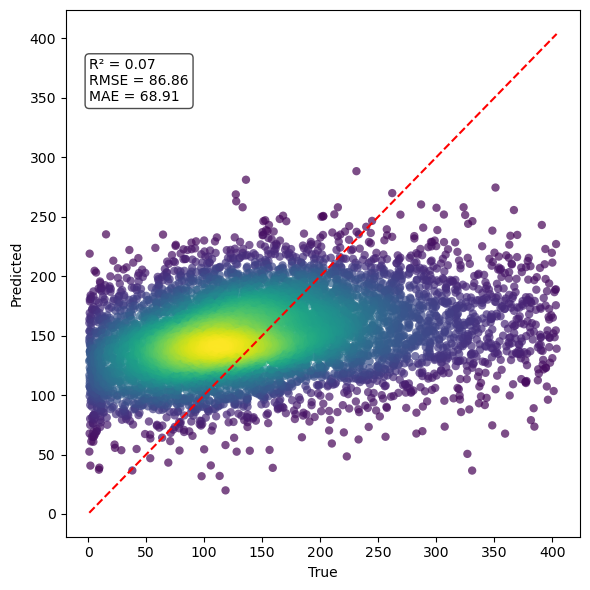

In [57]:
# Calcular densidade
xy = np.vstack([obs, preds])
z = gaussian_kde(xy)(xy)

# Criar DataFrame e ordenar por densidade
df_plot = pd.DataFrame({'True': obs, 'Predicted': preds, 'Density': z})
df_plot = df_plot.sort_values(by='Density')

# Calcular métricas
r2 = r2_score(df_plot['True'], df_plot['Predicted'])
rmse = mean_squared_error(df_plot['True'], df_plot['Predicted'], squared=False)
mae = mean_absolute_error(df_plot['True'], df_plot['Predicted'])

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(df_plot['True'], df_plot['Predicted'], c=df_plot['Density'], cmap='viridis',
            alpha=0.7, edgecolor='none')

# 1:1 line
min_val = min(df_plot['True'].min(), df_plot['Predicted'].min())
max_val = max(df_plot['True'].max(), df_plot['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

# Labels
plt.xlabel("True")
plt.ylabel("Predicted")

# Remover grid e título
plt.grid(False)

# Caixa com métricas
plt.text(min_val, max_val * 0.95,
         f"R² = {r2:.2f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}",
         verticalalignment='top',
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

In [58]:
len(val_preds)


6230

<AxesSubplot: >

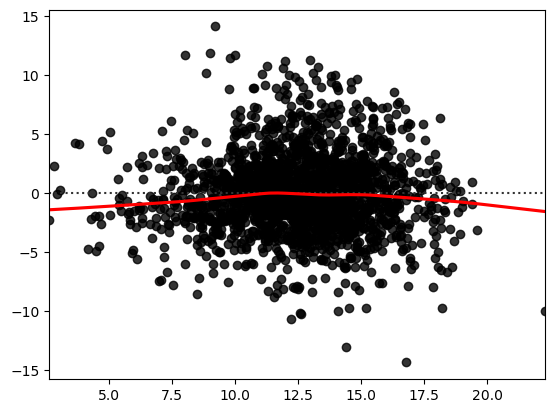

In [151]:
sns.residplot(x=preds, y=obs, lowess=True, line_kws={'color': 'red'},color='black')

### Exploring failed predictions

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Step 1: Identify problematic prediction indices
# problematic_value = 115.0
# tolerance = 1.0

# problematic_indices = np.where(np.isclose(val_preds, problematic_value, atol=tolerance))[0]
# print(f"Found {len(problematic_indices)} problematic predictions.")

In [ ]:


# # Step 2: Plot NDVI time series for these indices
# # Assuming NDVI is the first band (index 0)
# plt.figure(figsize=(10, 6))

# for idx in problematic_indices:
#     x_tensor, _ = val_ds[idx]        # x_tensor: shape [T, BANDS]
#     x_np = x_tensor.numpy()          # convert to numpy
#     ndvi_ts = x_np[:, 0]             # NDVI time series

#     plt.plot(ndvi_ts, alpha=0.5, label=f'Idx {idx}')

# plt.xlabel("Time step")
# plt.ylabel("NDVI")
# plt.title("NDVI Time Series for Problematic Predictions (~115)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()



## Try Random Forest model

In [59]:
# hls_cols
target_col

'agbd'

In [60]:

X_train_vi = train_df[hls_cols].dropna()
y_train_vi = train_df.loc[X_train_vi.index, target_col]

X_val_vi = val_df[hls_cols].dropna()
y_val_vi = val_df.loc[X_val_vi.index, target_col]

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf_vi = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_vi.fit(X_train_vi, y_train_vi)
y_pred_vi = rf_vi.predict(X_val_vi)

/opt/conda/envs/pangeo/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


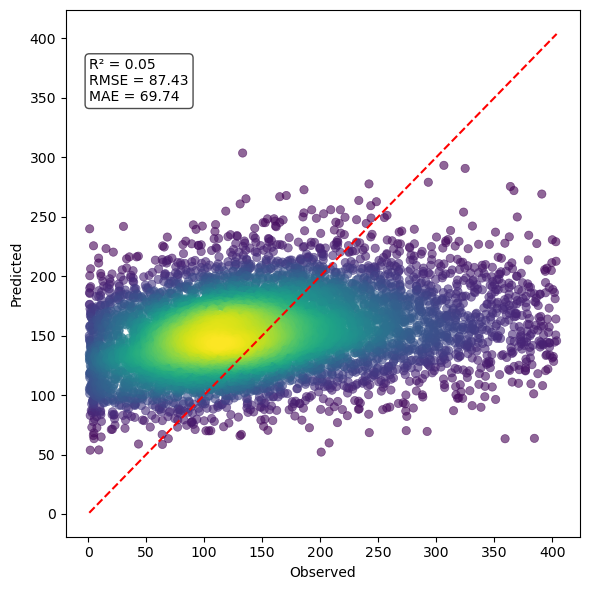

In [62]:

# Plot test 2
# Prepare data
xy = np.vstack([y_val_vi, y_pred_vi])
z = gaussian_kde(xy)(xy)

# Create DataFrame for seaborn
df_plot = pd.DataFrame({
    'Observed': y_val_vi,
    'Predicted': y_pred_vi,
    'Density': z
})

# Sort by density
df_plot = df_plot.sort_values(by='Density')

# Calculate metrics
r2_rf = r2_score(df_plot['Observed'], df_plot['Predicted'])
rmse_rf = mean_squared_error(df_plot['Observed'], df_plot['Predicted'], squared=False)
mae_rf = mean_absolute_error(df_plot['Observed'], df_plot['Predicted'])

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_plot, x='Observed', y='Predicted', hue='Density',
                palette='viridis', edgecolor=None, alpha=0.6, legend=False)

# 1:1 line
min_val = min(df_plot['Observed'].min(), df_plot['Predicted'].min())
max_val = max(df_plot['Observed'].max(), df_plot['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

# Labels
plt.xlabel("Observed")
plt.ylabel("Predicted")

# Remove title and grid
plt.grid(False)

# Add metrics to plot
plt.text(min_val, max_val * 0.95,
         f"R² = {r2_rf:.2f}\nRMSE = {rmse_rf:.2f}\nMAE = {mae_rf:.2f}",
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

<Axes: xlabel='Predicted', ylabel='Observed'>

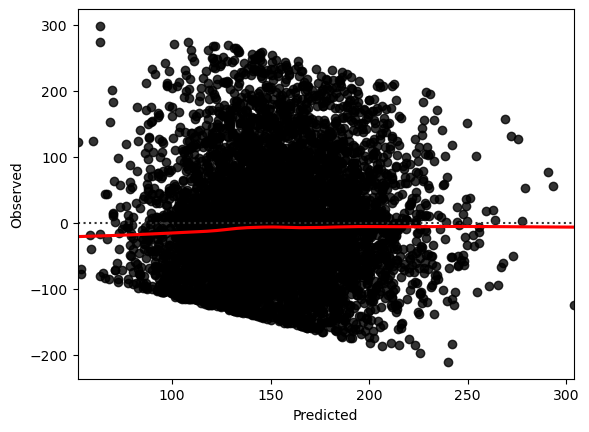

In [63]:
sns.residplot(x=df_plot['Predicted'], y=df_plot['Observed'], lowess=True, line_kws={'color': 'red'},color='black')


In [ ]:
predictions_df_rf_path = '/panfs/ccds02/nobackup/people/rvieiral/projects/HLS/models/hls_1dcnn_tests/run_20250729_145227/val_predictions_rf.csv'
pd.DataFrame({"true": df_plot['Observed'] , "pred": df_plot['Predicted']}).to_csv(predictions_df_rf_path, index=False)
# predictions_df_path

## Sanity check

In [64]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, r2_score

# -----------------------
# Config
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs        = 100
lr            = 3e-3
weight_decay  = 1e-2          # set to 0 for overfit sanity test
patience      = 15
grad_clip     = 1.0
use_log_scale = target_col.endswith("_log")  # True if training on log1p(target)

# -----------------------
# Build model
# -----------------------
time_keys = sorted(hls_by_time.keys())
seq_len   = len(time_keys)
n_bands   = len(hls_by_time[time_keys[0]])

# OPTION A: ResNet + Attention (recommended)
# model = ResNet1DAttn(n_bands, seq_len, n_blocks=3, hidden_dim=64).to(device)

# OPTION B: Simple 1D CNN
# model = HLS1DCNN(n_bands=n_bands, hidden_dim=64, kernel_size=3).to(device)

# -----------------------
# Loss & optimizer
# -----------------------
criterion = nn.MSELoss() if use_log_scale else nn.SmoothL1Loss(beta=1.0)  # Huber for raw targets
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=False)

# -----------------------
# Helpers
# -----------------------
def _to_numpy(t):
    return t.detach().cpu().numpy()

def evaluate(model, loader):
    model.eval()
    all_pred, all_true = [], []
    loss_sum, n_obs = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float()
            pred = model(xb).float()
            if pred.ndim == 2 and pred.shape[1] == 1:
                pred = pred.squeeze(1)
            loss = criterion(pred, yb)
            bs = yb.size(0)
            loss_sum += loss.item() * bs
            n_obs += bs

            p = _to_numpy(pred)
            y = _to_numpy(yb)

            # Invert log scale for metrics if applicable
            if use_log_scale:
                p = np.expm1(p)
                y = np.expm1(y)

            all_pred.append(p)
            all_true.append(y)

    y_pred = np.concatenate(all_pred)
    y_true = np.concatenate(all_true)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = r2_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else np.nan
    avg_loss = loss_sum / max(n_obs, 1)
    return avg_loss, mae, rmse, r2

# -----------------------
# Training loop with early stopping
# -----------------------
best_val = float("inf")
best_state = None
epochs_no_improve = 0

for epoch in range(1, epochs + 1):
    model.train()
    train_loss_sum, train_count = 0.0, 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float()

        optimizer.zero_grad()
        pred = model(xb).float()
        if pred.ndim == 2 and pred.shape[1] == 1:
            pred = pred.squeeze(1)

        loss = criterion(pred, yb)
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_loss_sum += loss.item() * yb.size(0)
        train_count += yb.size(0)

    train_loss = train_loss_sum / max(train_count, 1)
    val_loss, val_mae, val_rmse, val_r2 = evaluate(model, val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:03d} | "
          f"Train {train_loss:.4f} | "
          f"Val {val_loss:.4f} | "
          f"MAE {val_mae:.3f} | RMSE {val_rmse:.3f} | R² {val_r2:.3f}")

    # Early stopping
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best val loss: {best_val:.4f}")
            break

# Restore best weights
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'